In [ ]:
import pandas as pd
import json
from tqdm import tqdm

def load_json(path, max_lines=None):
    data = []
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

df = load_json("Clothing_Shoes_and_Jewelry_5.json", max_lines=50000)

df = df[['reviewerID', 'asin', 'reviewText', 'overall']]
df = df.dropna(subset=['reviewText'])

MIN_REVIEWS = 5
user_counts = df['reviewerID'].value_counts()
item_counts = df['asin'].value_counts()
df = df[df['reviewerID'].isin(user_counts[user_counts >= MIN_REVIEWS].index)]
df = df[df['asin'].isin(item_counts[item_counts >= MIN_REVIEWS].index)]

df = df.reset_index(drop=True)

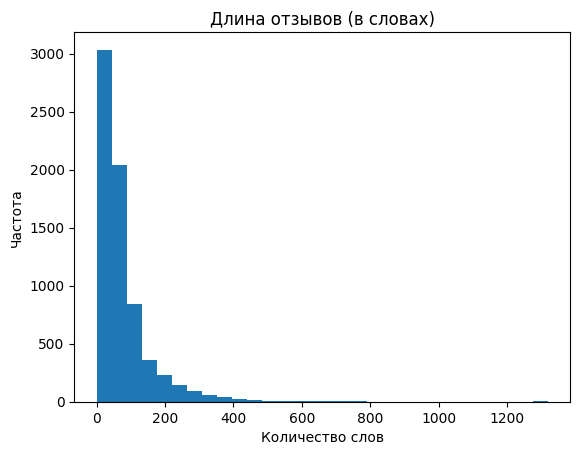

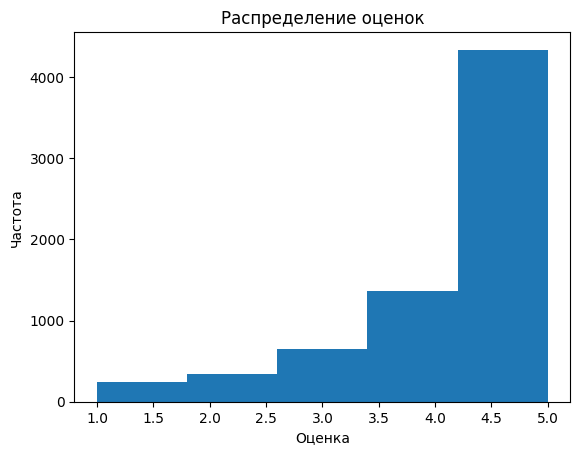

In [9]:
import matplotlib.pyplot as plt

df['review_len'] = df['reviewText'].apply(lambda x: len(x.split()))
plt.hist(df['review_len'], bins=30)
plt.title("Длина отзывов (в словах)")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

plt.hist(df['overall'], bins=5)
plt.title("Распределение оценок")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

y = df['overall'].values

vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df['reviewText']).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучние моделей

## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
pred_ridge = model_ridge.predict(X_test)

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)

## Gradient Boosting (LightGBM)

In [15]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1)
model_lgb.fit(X_train, y_train)
pred_lgb = model_lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51198
[LightGBM] [Info] Number of data points in the train set: 5538, number of used features: 500
[LightGBM] [Info] Start training from score 4.328097


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(model_name, y_true, y_pred):
    print(f"{model_name}")
    print(f"    MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"    MAE: {mean_absolute_error(y_true, y_pred):.4f}\n")

evaluate("Ridge", y_test, pred_ridge)
evaluate("Random Forest", y_test, pred_rf)
evaluate("LightGBM", y_test, pred_lgb)

Ridge
    MSE: 0.7979
    MAE: 0.6712

Random Forest
    MSE: 0.8798
    MAE: 0.7000

LightGBM
    MSE: 0.7917
    MAE: 0.6376



In [19]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/roman/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

task = Task('reg', metric='mae')

automl = TabularAutoML(
    task=task,
    timeout=1200,
    cpu_limit=2,
    reader_params={
        'n_jobs': 4,
        'cv': 5,
        'random_state': 42
    }
)

oof_pred = automl.fit_predict(train_data, roles={'target': 'overall'})

/home/roman/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:1052: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cnts = concat([cnts, Series([cnts.shape[0] + 1], index=[np.nan])])
/home/roman/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [32]:
test_pred = automl.predict(test_data)

mse = mean_squared_error(test_data['overall'], test_pred.data)
mae = mean_absolute_error(test_data['overall'], test_pred.data)

print(f"LightAutoML:")
print(f"    MSE: {mse:.4f}")
print(f"    MAE: {mae:.4f}")

LightAutoML:
  MSE: 1.0225
  MAE: 0.7932
